In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib import image as img
from PIL import Image
import torch
from torch.utils.data import Dataset, random_split
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import os
import torchvision
import gc

folder_path = '/content/drive/MyDrive/global-wheat-detection/'

# Read the CSV file using pandas
train_file = pd.read_csv(folder_path + 'train.csv')

def group_boxes(group):
    boundaries = group["bbox"].str.split(",", expand = True)
    boundaries[0] = boundaries[0].str.slice(start = 1)
    boundaries[3] = boundaries[3].str.slice(stop = -1)
    
    return boundaries.values.astype(float)

labels = train_file.groupby("image_id").apply(group_boxes)

train_image_ids = np.unique(labels.index.values)[0:1440]
val_image_ids = np.unique(labels.index.values)[1440:1500]
# train_image_ids = np.unique(labels.index.values)[0:27]
# val_image_ids = np.unique(labels.index.values)[27:30]

labels

Mounted at /content/drive


image_id
00333207f    [[0.0, 654.0, 37.0, 111.0], [0.0, 817.0, 135.0...
005b0d8bb    [[765.0, 879.0, 116.0, 79.0], [84.0, 539.0, 15...
006a994f7    [[437.0, 988.0, 98.0, 36.0], [309.0, 527.0, 11...
00764ad5d    [[89.0, 256.0, 113.0, 107.0], [216.0, 282.0, 1...
00b5fefed    [[709.0, 97.0, 204.0, 105.0], [775.0, 250.0, 1...
                                   ...                        
ffb445410    [[0.0, 534.0, 54.0, 118.0], [0.0, 480.0, 38.0,...
ffbf75e5b    [[0.0, 697.0, 21.0, 58.0], [104.0, 750.0, 77.0...
ffbfe7cc0    [[256.0, 0.0, 64.0, 99.0], [390.0, 0.0, 48.0, ...
ffc870198    [[447.0, 976.0, 78.0, 48.0], [18.0, 141.0, 218...
ffdf83e42    [[306.0, 178.0, 67.0, 88.0], [367.0, 167.0, 63...
Length: 3373, dtype: object

In [6]:
####################### SOME CODE FOR INTERPRETATION ###########################
image_ids = []
bounding_boxes = []

for image_id in labels.index:
    # Append the image ID to the image_ids array
    image_ids.append(image_id)
    
    # Append the bounding boxes of the current image to the bounding_boxes array
    bounding_boxes.append(labels[image_id])

# Convert the bounding_boxes array to a NumPy array
image_ids = np.array(image_ids)
bounding_boxes = np.array(bounding_boxes)

image_ids = image_ids[0:1500]
bounding_boxes = bounding_boxes[0:1500]
# image_ids = image_ids[0:30]
# bounding_boxes = bounding_boxes[0:30]
# Print the arrays
print("Image IDs:", image_ids[499])
print("Bounding Boxes:\n", bounding_boxes[0][0])
print(f"length of image_ids is {len(image_ids)}")
print(f"length of bounding_boxes is {len(bounding_boxes)}")

Image IDs: 27da826ad
Bounding Boxes:
 [  0. 654.  37. 111.]
length of image_ids is 1500
length of bounding_boxes is 1500


<ipython-input-6-e5556cc5c9b9>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bounding_boxes = np.array(bounding_boxes)


In [7]:
rescaled_bounding_boxes = bounding_boxes*0.25

In [4]:
##################### Normalizing the images #####################
images=[]
for i in range(len(image_ids)):
    image = Image.open(folder_path + 'train/' + image_ids[i] + ".jpg")
    image = image.resize((256, 256))
    images.append(image)

images = np.array(images)

normalized_images = []
for img in images:
    normalized_img = np.array(img) / 255.0
    normalized_images.append(normalized_img)

normalized_images = np.array(normalized_images)


<ipython-input-4-b5759a0e28fb>:8: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  images = np.array(images)
<ipython-input-4-b5759a0e28fb>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images = np.array(images)


In [8]:
############################# DATA LOADER ######################################
image_size = (256, 256)  # Size of the input image
grid_size = (32, 32)

class WheatDataset(Dataset):
    def __init__(self, images, bounding_boxes):
        self.images = images
        self.bounding_boxes = bounding_boxes
        self.transform = transforms.Compose([
            transforms.ToTensor() 
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        bbox = self.bounding_boxes[index]

        # Convert the image and bbox to tensors
        image_tensor = self.transform(image)

        img_grid, bbox_array = self.convert_to_yolo_format(bbox, image_size, grid_size)# Conversion to YOLO FORMAT @@

        bbox_tensor = torch.from_numpy(bbox_array)

        return image_tensor, bbox_tensor, img_grid

    def rect_intersect(self, cell, bboxes):
        cell_x, cell_y, cell_width, cell_height = cell
        cell_x_max = cell_x + cell_width
        cell_y_max = cell_y + cell_height

        anchor_one = np.zeros(5)
        anchor_two = np.zeros(5)

        for i in range(len(bboxes)):
          box_x, box_y, box_width, box_height = bboxes[i]
          box_x_center = box_x + box_width / 2
          box_y_center = box_y + box_height / 2

          if (
              box_x_center >= cell_x
              and box_x_center < cell_x_max
              and box_y_center >= cell_y
              and box_y_center < cell_y_max
          ):
              if np.all(anchor_one == 0):
                  anchor_one = self.yolo_shape(bboxes[i], cell)
              elif np.all(anchor_two == 0):
                  anchor_two = self.yolo_shape(bboxes[i], cell)
              else:
                  break

        return np.concatenate((anchor_one, anchor_two), axis=None)


    def convert_to_yolo_format(self, bboxes, image_size, grid_size):
        cell_width = image_size[0] / grid_size[0]
        cell_height = image_size[1] / grid_size[1]

        image_grid = np.zeros((grid_size[0], grid_size[1], 4))
        label_grid = np.zeros((grid_size[0], grid_size[1], 10))

        cell = [0, 0, cell_width, cell_height]

        for i in range(grid_size[0]):
            for j in range(grid_size[1]):
                image_grid[i, j] = cell

                intersected_bboxes = self.get_intersected_bboxes(bboxes, cell)

                if len(intersected_bboxes) > 0:
                    yolo_anchors = [self.rect_intersect(cell, intersected_bboxes)]
                    label_grid[i, j] = np.concatenate(yolo_anchors, axis=None)

                cell[0] += cell_width
                cell[2] = cell_width

            cell[0] = 0
            cell[1] += cell_height
            cell[3] = cell_height

        return image_grid, label_grid

    def get_intersected_bboxes(self, bboxes, cell):
        cell_x, cell_y, cell_width, cell_height = cell
        cell_x_max = cell_x + cell_width
        cell_y_max = cell_y + cell_height
        
        intersected_bboxes = []
        
        
        # for bbox in bboxes:
        for i in range(len(bboxes)):
          # print(bbox)
          box_x, box_y, box_width, box_height = bboxes[i]
          box_x_center = box_x + box_width / 2
          box_y_center = box_y + box_height / 2
          
          if box_x_center >= cell_x and box_x_center < cell_x_max and box_y_center >= cell_y and box_y_center < cell_y_max:
              intersected_bboxes.append(bboxes[i])
        
        return intersected_bboxes

    def yolo_shape(self, bbox, cell):

        box_x, box_y, box_width, box_height = bbox
        cell_x, cell_y, cell_width, cell_height = cell
        
        # Calculate the center coordinates of the bounding box
        box_x_center = box_x + box_width / 2
        box_y_center = box_y + box_height / 2
        
        # Offset the bounding box coordinates relative to the cell coordinates
        box_x_offset = (box_x_center - cell_x) / cell_width
        box_y_offset = (box_y_center - cell_y) / cell_height
        
        # Scale the bounding box width and height relative to the cell width and height
        box_width_scale = box_width / image_size[0]
        box_height_scale = box_height / image_size[1]
        
        # Create the YOLO-formatted anchor coordinates [1, box_x, box_y, box_width, box_height]
        yolo_anchors = [1, box_x_offset, box_y_offset, box_width_scale, box_height_scale]
        
        return yolo_anchors


In [6]:
##################### SPLIT DATA INTO TRAIN AND VALIDATION #####################
def split_dataset(dataset, train_ratio=0.96):
    train_size = int(len(dataset) * train_ratio)
    valid_size = len(dataset) - train_size
    train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])
    return train_dataset, valid_dataset

dataset = WheatDataset(normalized_images, rescaled_bounding_boxes)

# Split the dataset
train_dataset, valid_dataset = split_dataset(dataset)

vb_size=2

# Create data loaders for training and validation
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=vb_size, shuffle=False)

# Create a dataloader from the dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=False)

In [2]:
#################### NETWORK ARCHITECTURE YOLO #################################

class YOLO(nn.Module):
    def __init__(self):
        super(YOLO, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.LeakyReLU(0.1)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.LeakyReLU(0.1)
        
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.relu3 = nn.LeakyReLU(0.1)
        
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.LeakyReLU(0.1)
        
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.relu5 = nn.LeakyReLU(0.1)
        
        self.conv6 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(64)
        self.relu6 = nn.LeakyReLU(0.1)
        
        self.conv7 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn7 = nn.BatchNorm2d(128)
        self.relu7 = nn.LeakyReLU(0.1)
        
        self.conv8 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.bn8 = nn.BatchNorm2d(256)
        self.relu8 = nn.LeakyReLU(0.1)
        
        self.conv9 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.bn9 = nn.BatchNorm2d(128)
        self.relu9 = nn.LeakyReLU(0.1)
        
        self.conv10 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn10 = nn.BatchNorm2d(256)
        self.relu10 = nn.LeakyReLU(0.1)
        
        self.conv11 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.bn11 = nn.BatchNorm2d(512)
        self.relu11 = nn.LeakyReLU(0.1)
        
        self.conv12 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)
        self.bn12 = nn.BatchNorm2d(256)
        self.relu12 = nn.LeakyReLU(0.1)
        
        self.conv13 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn13 = nn.BatchNorm2d(512)
        self.relu13 = nn.LeakyReLU(0.1)
        
        self.conv14 = nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1)
        self.bn14 = nn.BatchNorm2d(1024)
        self.relu14 = nn.LeakyReLU(0.1)
        
        self.conv15 = nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1)
        self.bn15 = nn.BatchNorm2d(512)
        self.relu15 = nn.LeakyReLU(0.1)
        
        self.conv16 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
        self.bn16 = nn.BatchNorm2d(1024)
        self.relu16 = nn.LeakyReLU(0.1)
        
        self.conv17 = nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1)
        self.bn17 = nn.BatchNorm2d(512)
        self.relu17 = nn.LeakyReLU(0.1)
        
        self.conv18 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
        self.bn18 = nn.BatchNorm2d(1024)
        self.relu18 = nn.LeakyReLU(0.1)
        
        self.conv19 = nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1)
        self.bn19 = nn.BatchNorm2d(512)
        self.relu19 = nn.LeakyReLU(0.1)
        
        self.conv20 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
        self.bn20 = nn.BatchNorm2d(1024)
        self.relu20 = nn.LeakyReLU(0.1)
        
        self.conv21 = nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1)
        self.bn21 = nn.BatchNorm2d(512)
        self.relu21 = nn.LeakyReLU(0.1)
        
        self.conv22 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)
        self.bn22 = nn.BatchNorm2d(256)
        self.relu22 = nn.LeakyReLU(0.1)
        
        self.conv23 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.bn23 = nn.BatchNorm2d(128)
        self.relu23 = nn.LeakyReLU(0.1)
        
        self.conv24 = nn.Conv2d(128, 10, kernel_size=1, stride=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu1(self.bn1(self.conv1(x)))
        
        x = self.relu2(self.bn2(self.conv2(x)))
        shortcut = x
        
        for _ in range(2):
            x = self.relu3(self.bn3(self.conv3(x)))
            x = self.relu4(self.bn4(self.conv4(x)))
            x = self.relu5(x + shortcut)
            shortcut = x
        
        x = self.relu6(self.bn5(self.conv5(x)))
        shortcut = x
        
        for _ in range(2):
            x = self.relu6(self.bn6(self.conv6(x)))
            x = self.relu7(self.bn7(self.conv7(x)))
            x = self.relu8(x + shortcut)
            shortcut = x
        
        x = self.relu9(self.bn8(self.conv8(x)))
        shortcut = x
        
        for _ in range(8):
            x = self.relu9(self.bn9(self.conv9(x)))
            x = self.relu10(self.bn10(self.conv10(x)))
            x = self.relu11(x + shortcut)
            shortcut = x
        
        x = self.relu12(self.bn11(self.conv11(x)))
        shortcut = x
        
        for _ in range(8):
            x = self.relu12(self.bn12(self.conv12(x)))
            x = self.relu13(self.bn13(self.conv13(x)))
            x = self.relu14(x + shortcut)
            shortcut = x
        
        x = self.relu15(self.bn14(self.conv14(x)))
        shortcut = x
        
        for _ in range(4):
            x = self.relu15(self.bn15(self.conv15(x)))
            x = self.relu16(self.bn16(self.conv16(x)))
            x = self.relu17(x + shortcut)
            shortcut = x
        
        x = self.relu18(self.bn17(self.conv17(x)))
        x = self.relu18(self.bn18(self.conv18(x)))
        x = self.relu19(self.bn19(self.conv19(x)))
        x = self.relu20(self.bn20(self.conv20(x)))
        x = self.relu21(self.bn21(self.conv21(x)))
        x = self.relu22(self.bn22(self.conv22(x)))
        x = self.relu23(self.bn23(self.conv23(x)))
        
        x = self.sigmoid(self.conv24(x))
        
        return x


cuda
Epoch [1/10], Loss: 0.0091
Epoch [2/10], Loss: 0.0034
Epoch [3/10], Loss: 0.0029
Epoch [4/10], Loss: 0.0026
Epoch [5/10], Loss: 0.0024
Epoch [6/10], Loss: 0.0023
Epoch [7/10], Loss: 0.0022
Epoch [8/10], Loss: 0.0021
Epoch [9/10], Loss: 0.0020
Epoch [10/10], Loss: 0.0020
Training complete!


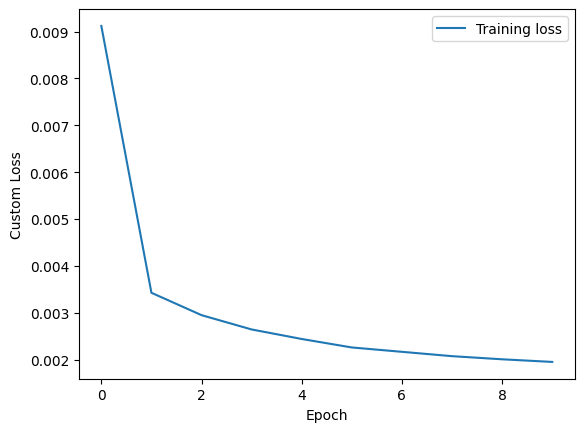

In [8]:
#######################TRAINING THE MODEL ######################################
gc.collect()
torch.cuda.empty_cache()
train_loss=[]

def plot_losses(epoch_loss, label):
    plt.plot(epoch_loss, label=label)
    plt.xlabel("Epoch")
    plt.ylabel("Custom Loss")
    plt.legend()
    plt.show()

def train(model, train_loader, criterion, optimizer, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        
        for inputs, labels, _ in train_loader:
            inputs = inputs.to(device).float()
            labels = labels.to(device).float()
            
            # Forward pass
            inputs = inputs.to(torch.float32)
            outputs = model(inputs)
            outputs = outputs.permute(0, 2, 3, 1) 

            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        # Calculate average loss for the epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        train_loss.append(epoch_loss)
        
        # Print the average loss for the epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    
    print("Training complete!")

model = YOLO()
# model.float()  # added to cater custom loss
torch.cuda.empty_cache()
train_loader = train_loader
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

train(model, train_loader, criterion, optimizer, num_epochs)

plot_losses(train_loss, label="Training loss")

torch.save(model.state_dict(), folder_path + 'model_weights_huber.pth')

In [10]:
def prediction_to_bbox(bboxes, image_grid):
    bboxes = bboxes.clone()
    
    im_width = (image_grid[:,:,2] * 32)
    im_height = (image_grid[:,:,3] * 32)
    
    # descale x,y
    bboxes[:,:,1] = (bboxes[:,:,1] * image_grid[:,:,2]) + image_grid[:,:,0]
    bboxes[:,:,2] = (bboxes[:,:,2] * image_grid[:,:,3]) + image_grid[:,:,1]
    bboxes[:,:,6] = (bboxes[:,:,6] * image_grid[:,:,2]) + image_grid[:,:,0]
    bboxes[:,:,7] = (bboxes[:,:,7] * image_grid[:,:,3]) + image_grid[:,:,1]
    
    # descale width,height
    bboxes[:,:,3] = bboxes[:,:,3] * im_width 
    bboxes[:,:,4] = bboxes[:,:,4] * im_height
    bboxes[:,:,8] = bboxes[:,:,8] * im_width 
    bboxes[:,:,9] = bboxes[:,:,9] * im_height
    
    # centre x,y to top left x,y
    bboxes[:,:,1] = bboxes[:,:,1] - (bboxes[:,:,3] / 2)
    bboxes[:,:,2] = bboxes[:,:,2] - (bboxes[:,:,4] / 2)
    bboxes[:,:,6] = bboxes[:,:,6] - (bboxes[:,:,8] / 2)
    bboxes[:,:,7] = bboxes[:,:,7] - (bboxes[:,:,9] / 2)
    
    # width,heigth to x_max,y_max
    bboxes[:,:,3] = bboxes[:,:,1] + bboxes[:,:,3]
    bboxes[:,:,4] = bboxes[:,:,2] + bboxes[:,:,4]
    bboxes[:,:,8] = bboxes[:,:,6] + bboxes[:,:,8]
    bboxes[:,:,9] = bboxes[:,:,7] + bboxes[:,:,9]
    
    return bboxes


def non_max_suppression(predictions, top_n):
    probabilities = torch.cat((predictions[:,:,0].flatten(), predictions[:,:,5].flatten()))
    
    first_anchors = predictions[:,:,1:5].reshape((32*32, 4))
    second_anchors = predictions[:,:,6:10].reshape((32*32, 4))
    
    bboxes = torch.cat(
        (first_anchors, second_anchors),
        dim=0
    )
    bboxes = bboxes.detach().numpy()
    bboxes = switch_x_y(bboxes)
    bboxes, probabilities = select_top(probabilities, bboxes, top_n=top_n)
    bboxes = switch_x_y(bboxes)
    
    return bboxes


def switch_x_y(bboxes):
    x1 = bboxes[:, 0].copy()
    y1 = bboxes[:, 1].copy()
    x2 = bboxes[:, 2].copy()
    y2 = bboxes[:, 3].copy()
    
    bboxes[:, 0] = y1
    bboxes[:, 1] = x1
    bboxes[:, 2] = y2
    bboxes[:, 3] = x2
    
    return bboxes


def select_top(probabilities, boxes, top_n=10):
  
    probabilities = probabilities.detach().cpu().numpy()

    selected_indices = torch.tensor(
        torchvision.ops.nms(
            torch.tensor(boxes),
            torch.tensor(probabilities),
            iou_threshold=0.3
        )
    )
    
    return boxes[selected_indices], probabilities[selected_indices]


def process_predictions(predictions, image_ids, image_grid):
    bboxes = {}
    
    print("image ids received inside process_predictions are ")
    print(image_ids)
    for i, image_id in enumerate(image_ids):
        predictions[i] = prediction_to_bbox(predictions[i], image_grid)
        bboxes[image_id] = non_max_suppression(predictions[i], top_n=100)
        
        # back to coco shape
        bboxes[image_id][:,2:4] = bboxes[image_id][:,2:4] - bboxes[image_id][:,0:2]
    
    return bboxes

mm = YOLO()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

i=0

for inputs, labels, image_grid in valid_loader:
    si = i*vb_size
    if (i+1)*vb_size < len(val_image_ids):
      ei = (i+1)*vb_size
    else:
      ei = len(val_image_ids) 
    inputs = inputs.to(device)
    labels = labels.to(device)
    inputs = inputs.to(torch.float32)
    inputs = inputs.cpu()
    val_predictions = mm.forward(inputs)
    val_predictions = val_predictions.permute(0, 2, 3, 1)
    print(f"shape of val_predictions is {val_predictions.shape}")
    print(f"shape of image_grid is {image_grid.shape}")
    val_predictions = process_predictions(val_predictions, val_image_ids[si:ei], image_grid[0])



7220f6fa6


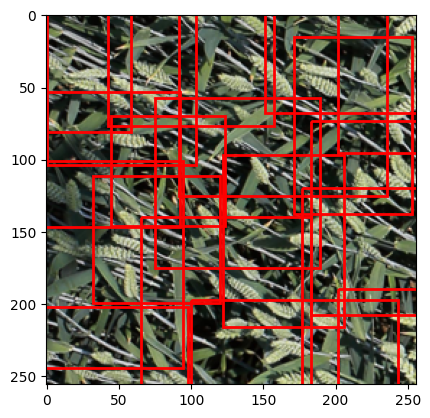

7227652d3


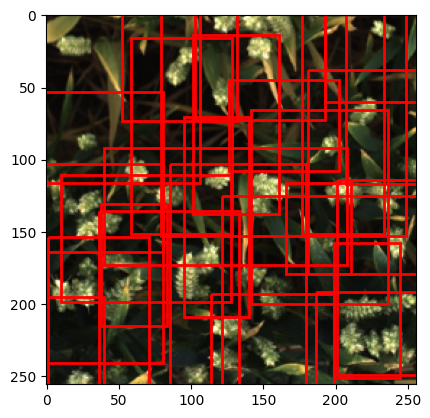

In [10]:
for valid_image_ids in val_predictions:
    print(valid_image_ids)
    im = Image.open(folder_path + 'train/' + valid_image_ids + ".jpg")
    im = im.resize((256, 256))

    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(im)

    bbox_array = val_predictions[valid_image_ids]

    for i in range(len(bbox_array)):
        x, y, width, height = bbox_array[i]

        # Create a rectangle patch
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')

        # Add the rectangle patch to the axes
        ax.add_patch(rect)

    # Show the image with bounding boxes
    plt.show()


In [14]:
def form_image_grid():    
    image_grid = np.zeros((32, 32, 4))

    # x, y, width, height
    cell = [0, 0, 256 / 32, 256 / 32] 

    for i in range(0, 32):
        for j in range(0, 32):
            image_grid[i,j] = cell

            cell[0] = cell[0] + cell[2]

        cell[0] = 0
        cell[1] = cell[1] + cell[3]

    return image_grid
image_grid = form_image_grid()
image_grid = torch.from_numpy(image_grid)
t_model = YOLO()
model_weights_path = folder_path + 'model_weights_huber.pth'
t_model.load_state_dict(torch.load(model_weights_path))
# t_model.eval()
test_predictions = []
test_image_ids = os.listdir(folder_path + 'test/')
test_image_ids = [image_id[:-4] for image_id in test_image_ids]
test_image_ids = test_image_ids[3:10]
for i, image_id in enumerate(test_image_ids):
    image = Image.open(folder_path + 'test/' + image_id + ".jpg")
    im = image.resize((256, 256)) 
    image = np.asarray(im) / 255

    array = np.array([image_id])

    # image = torch.from_numpy(image)
    img_tensor = torch.from_numpy(image)
    img_tensor = img_tensor.to(torch.float32)
    img_tensor = img_tensor.permute(2,0,1)
    img_tensor = img_tensor.unsqueeze(0)

    # test_predictions = t_model.forward(img_tensor)
    test_predictions = t_model.forward(img_tensor)###########################################
    test_predictions = test_predictions.permute(0, 2, 3, 1)
    print(f"shape of test_predictions before is {test_predictions.shape}")
    # test_predictions = test_predictions.unsqueeze(0)
    print(f"shape of test_predictions after is {test_predictions.shape}")
    test_predictionss = process_predictions(test_predictions, array, image_grid)

    print("array looks like this:")
    print(array)

    array = np.empty((0,))

    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(im)

    bbox_array = test_predictionss[image_id]

    for i in range(len(bbox_array)):
        x, y, width, height = bbox_array[i]

        # Create a rectangle patch
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')

        # Add the rectangle patch to the axes
        ax.add_patch(rect)

    # Show the image with bounding boxes
    plt.show()


Output hidden; open in https://colab.research.google.com to view.